# Final Project: IMDB Movie Reviews Sentiment Analysis


# Student Name: Eavan McBride

# Table of Contents
1. Background
2. Goal
3. Source Data
4. Initial Review of the Data
5. Data Wrangling
6. Machine Learning Methodology 
7. Deep Learning Guidelines
6. Conclusions and Recommendations

# 1. Background
IMDB is seeking to automatically identify the sentiment within their text-based movie reviews.

# 2. Goal
Train a sentiment classifier (Positive, Negative) on a corpus of the provided documents.
Here are the goals:

    a. Maximize Accuracy
    b. Accurately detect positive sentiment
    


# 3. Source Data
Dataset can be accessed from the following links.

• Download: https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

• Source Data: http://ai.stanford.edu/~amaas/data/sentiment/



# 4. Initial Review of the Data

    

##Load and Check Data

In [ ]:
# Instructions for loading data files from Google Drive into Colab: https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92

In [ ]:
# Connect Colab to Google Drive (Only needed once per session)
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import data
import pandas as pd
path = '/content/drive/MyDrive/Data/IMDB_Dataset.csv'
data = pd.read_csv(path)

In [ ]:
#Check import success
print(data.shape)
data.head(10)

(50000, 2)


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
5,"Probably my all-time favorite movie, a story o...",positive
6,I sure would like to see a resurrection of a u...,positive
7,"This show was an amazing, fresh & innovative i...",negative
8,Encouraged by the positive comments about this...,negative
9,If you like original gut wrenching laughter yo...,positive


In [ ]:
#Summary of the dataset
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
#sentiment Distrubution
data['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
#check for null data 
data.isnull().sum()

review       0
sentiment    0
dtype: int64

# 5. Data Wrangling

## Import Packages

In [ ]:
#Load the libraries
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re,string,unicodedata

import nltk
nltk.download('stopwords') ## Only Once per Session
nltk.download('wordnet')  ## Only Once per Session
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras.layers import LSTM,Dropout
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dropout
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

from wordcloud import WordCloud,STOPWORDS

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Make Target Variable an Integer

In [ ]:
#Binary integer classifier -- 0 as Negative and 1 as Positive
data.sentiment=data.sentiment.apply(lambda x: 0 if x=='negative' else 1)

In [ ]:
#Check binary integer classification
data['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

## Text Feature Analysis

In [ ]:
# # Indirect features
eng_stopwords = set(stopwords.words("english"))

data['count_sent']=data["review"].apply(lambda x: len(re.findall("\n",str(x)))+1)

#Word count in each comment:
data['count_word']=data["review"].apply(lambda x: len(str(x).split()))

#Unique word count
data['count_unique_word']=data["review"].apply(lambda x: len(set(str(x).split())))

#Letter count
data['count_letters']=data["review"].apply(lambda x: len(str(x)))

#punctuation count
data["count_punctuations"] =data["review"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

#upper case words count
data["count_words_upper"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

#title case words count
data["count_words_title"] = data["review"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

#Number of stopwords
data["count_stopwords"] = data["review"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

#Average length of the words
data["mean_word_len"] = data["review"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#Word count percent in each comment:
data['word_unique_percent']=data['count_unique_word']*100/data['count_word']

#Punct percent in each comment:
data['punct_percent']=data['count_punctuations']*100/data['count_word']

In [ ]:
## Reordering the columns 
data = data[['review', 'sentiment', 'count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
data.head()

,review,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,One of the other reviewers has mentioned that ...,1,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166
1,A wonderful little production. <br /><br />The...,1,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494
2,I thought this was a wonderful way to spend ti...,1,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386
3,Basically there's a family where a little boy ...,0,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826


In [ ]:
#Mean Values of Features
data.groupby(['sentiment'],as_index=False).mean()

,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent
0,0,1.0,229.46456,152.2662,1294.06436,53.59836,5.14632,24.72780,103.38132,4.623461,70.896372,23.447622
1,1,1.0,232.84932,152.0156,1324.79768,51.55876,4.56928,27.96804,104.31900,4.657892,70.164729,22.077985


The above table reveals that the mean value is similar for both sentiments in every feature. Since there are no startling differences, we can determine that these are not good predictors of sentiment. Machine learning and neural networks will need to be used for classification. 

## Text Mining

In [ ]:
# # Removing all punctuations from Text
# a. Clean Contractions or Chat Words
# b. Lower Casing
# c. Remove Stop Words
# d. Stemming (i.e. reducing inflected/derived words to their word stem)
# e. Lemmatization (i.e. reducing inflected/derived words to their word stem while ensuring the stem word belongs to the same language)
# f. Remove Emojis & Emoticons
# g. Remove Urls & HTML Tags
# h. Remove Punctuations (must be done after HTML and URL removal)

mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

def clean_contractions(text, mapping):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    text = ' '.join([mapping[t] if t in mapping else t for t in text.split(" ")])
    return text

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

def word_replace(text):
    return text.replace('<br />','')

stemmer = PorterStemmer()
def stem_words(text):
    return " ".join([stemmer.stem(word) for word in text.split()])

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_html(text):
    html_pattern = re.compile('<.*?>')
    return html_pattern.sub(r'', text)

def preprocess(text):
    text=clean_contractions(text,mapping)
    text=text.lower()
    text=word_replace(text)
    text=remove_urls(text)
    text=remove_html(text)
    text=remove_stopwords(text)
    text=remove_punctuation(text)
    text=lemmatize_words(text)
    
    return text

In [ ]:
#Apply text processing
data["reviews_p"] = data["review"].apply(lambda text: preprocess(text))
data.head()

,review,sentiment,count_sent,count_word,count_unique_word,count_letters,count_punctuations,count_words_upper,count_words_title,count_stopwords,mean_word_len,word_unique_percent,punct_percent,reviews_p
0,One of the other reviewers has mentioned that ...,1,1,307,208,1761,78,8,36,133,4.739414,67.752443,25.407166,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,1,1,162,114,998,44,2,12,66,5.166667,70.370370,27.160494,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,1,1,166,121,926,40,3,20,76,4.584337,72.891566,24.096386,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,0,1,138,96,748,42,3,13,62,4.427536,69.565217,30.434783,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",1,1,230,152,1317,56,1,31,96,4.730435,66.086957,24.347826,petter matteis love time money visually stunni...


## Visualization

### Word Cloud

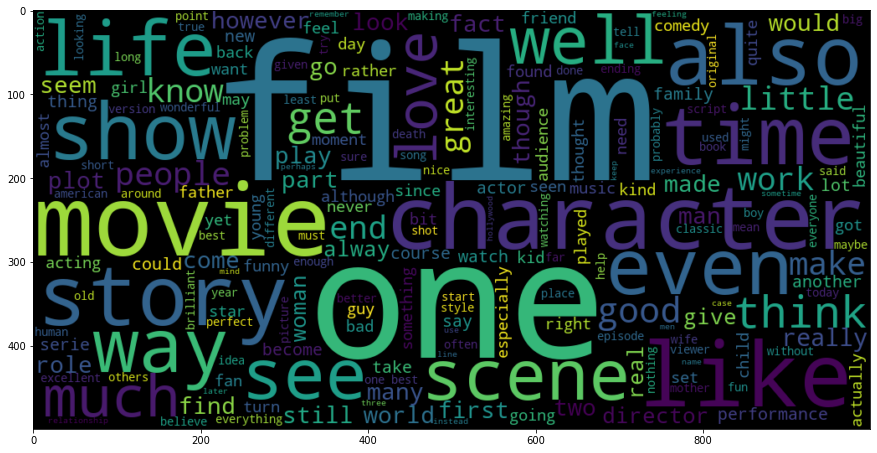

In [ ]:
# Positive Reviews
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 1].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')

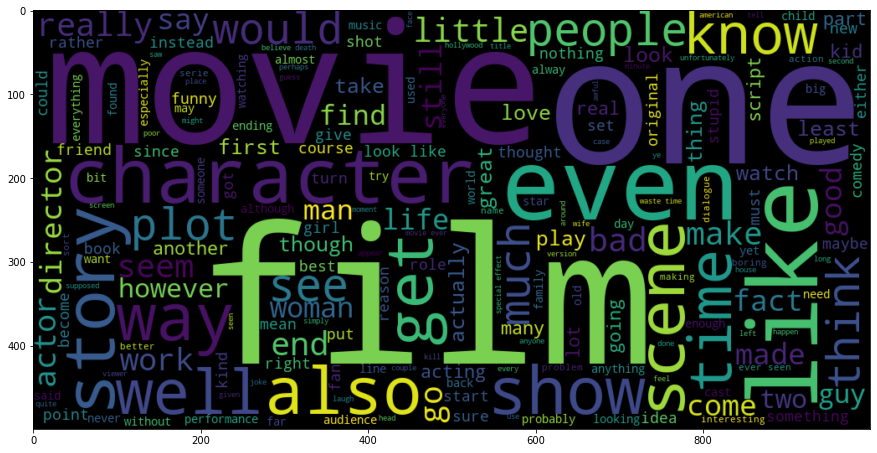

In [ ]:
#Negative Reviews
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 200 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.sentiment == 0].reviews_p))
plt.imshow(wc , interpolation = 'bilinear')

## N-gram Analysis

In [ ]:
texts = ' '.join(data['reviews_p'])

In [ ]:
string = texts.split(" ")

In [ ]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:7]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    print(n_gram_df.head())
    plt.figure(figsize = (10,5))
    return sns.barplot(x='count',y='word', data=n_gram_df)

Unigram Analysis

       word  count
0  (movie,)  98938
1   (film,)  89753
2    (one,)  52648
3   (like,)  39780
4  (would,)  30291


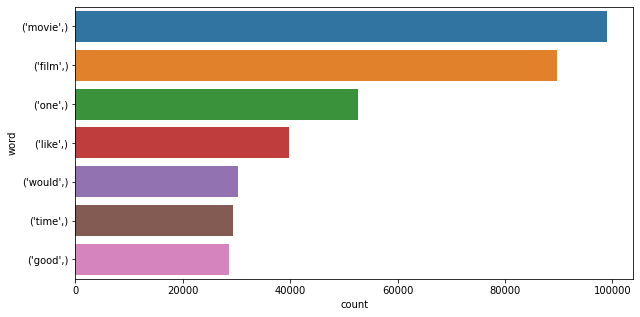

In [ ]:
draw_n_gram(string,1)

Bigram Analysis

                word  count
0       (look, like)   2874
1       (ever, seen)   2534
2  (special, effect)   2198
3      (movie, ever)   1937
4  (main, character)   1875


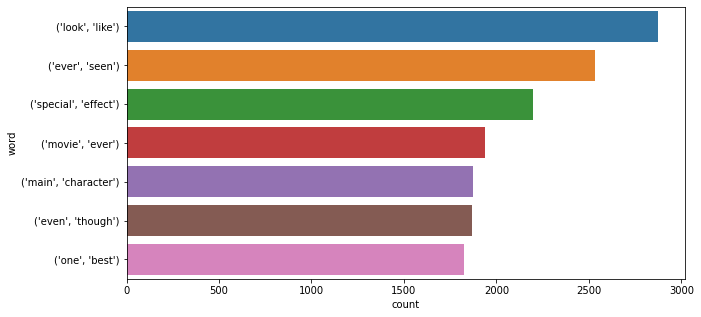

In [ ]:
draw_n_gram(string,2)

Trigram Analysis

                   word  count
0   (movie, ever, seen)    828
1  (worst, movie, ever)    731
2    (film, ever, seen)    413
3   (worst, film, ever)    344
4   (movie, ever, made)    337


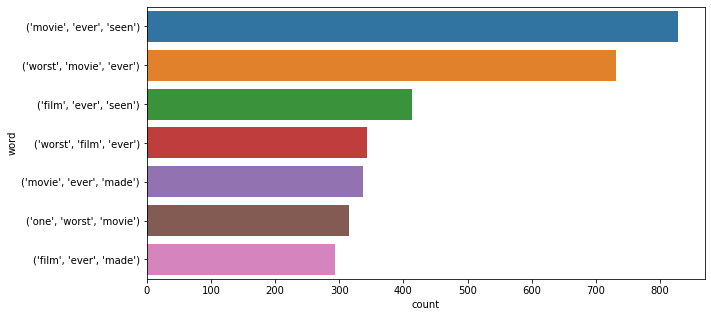

In [ ]:
draw_n_gram(string,3)

## Indirect Feature Analysis

In [ ]:
X=data[['count_sent', 'count_word', 'count_unique_word',
       'count_letters', 'count_punctuations', 'count_words_upper',
       'count_words_title', 'count_stopwords', 'mean_word_len',
       'word_unique_percent', 'punct_percent']]
y=data['sentiment']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=0)

In [ ]:
[i.shape for i in [X_train, X_test, y_train, y_test] ]

[(40000, 11), (10000, 11), (40000,), (10000,)]

In [ ]:
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='PiYG',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
    print("\nReport:",report)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


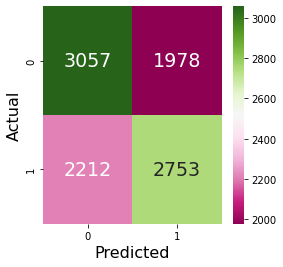


Accuracy:  0.58

F1 Score:  0.57

Report:               precision    recall  f1-score   support

           0       0.58      0.61      0.59      5035
           1       0.58      0.55      0.57      4965

    accuracy                           0.58     10000
   macro avg       0.58      0.58      0.58     10000
weighted avg       0.58      0.58      0.58     10000



In [ ]:
# Logistic Regression with Indirect features
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(X_train, y_train)
metrics(classifier,X_test,y_test)

# 6. Machine Learning Methodology

## Define Model Output Function with Visualization

In [ ]:
def metrics(model,x,y):
    y_pred = model.predict(x)
    acc = accuracy_score(y, y_pred)
    f1=f1_score(y, y_pred)
    cm=confusion_matrix(y, y_pred)
    report=classification_report(y,y_pred)
    plt.figure(figsize=(4,4))
    sns.heatmap(cm,annot=True,cmap='PiYG',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
    plt.xlabel("Predicted",fontsize=16)
    plt.ylabel("Actual",fontsize=16)
    plt.show()
    print("\nAccuracy: ",round(acc,2))
    print("\nF1 Score: ",round(f1,2))
    print("\nReport:",report)

## Vectorization

In [ ]:
# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'], test_size=0.2,random_state=0)

In [ ]:
# TFIDF
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
    token_pattern=r'\w{1,}',
    stop_words='english',
    ngram_range=(1, 3),
    max_features=10000
)

word_vectorizer.fit(data['reviews_p'])

tfidf_train = word_vectorizer.transform(X_train)
tfidf_test = word_vectorizer.transform(X_test)

## Machine Learning Models

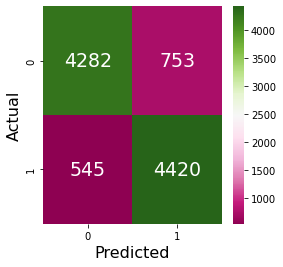


Accuracy:  0.87

F1 Score:  0.87

Report:               precision    recall  f1-score   support

           0       0.89      0.85      0.87      5035
           1       0.85      0.89      0.87      4965

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



In [ ]:
# Logistic Regression
classifier = LogisticRegression(C=0.1, solver='sag')
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

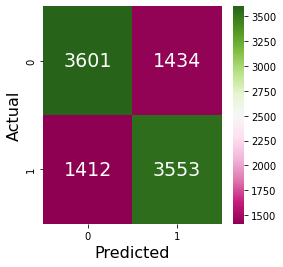


Accuracy:  0.72

F1 Score:  0.71

Report:               precision    recall  f1-score   support

           0       0.72      0.72      0.72      5035
           1       0.71      0.72      0.71      4965

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



In [ ]:
# Decision Tree
classifier = DecisionTreeClassifier()
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

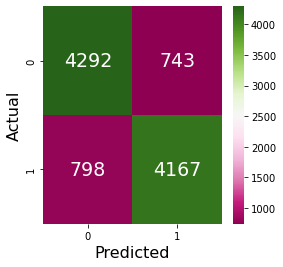


Accuracy:  0.85

F1 Score:  0.84

Report:               precision    recall  f1-score   support

           0       0.84      0.85      0.85      5035
           1       0.85      0.84      0.84      4965

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [ ]:
# Random Forest
classifier = RandomForestClassifier()
classifier.fit(tfidf_train, y_train)
metrics(classifier,tfidf_test,y_test)

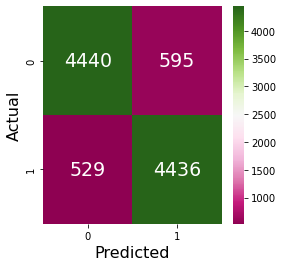


Accuracy:  0.89

F1 Score:  0.89

Report:               precision    recall  f1-score   support

           0       0.89      0.88      0.89      5035
           1       0.88      0.89      0.89      4965

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [ ]:
# Linear SVM

linear_svc = LinearSVC(penalty='l2')
linear_svc.fit(tfidf_train, y_train)
metrics(linear_svc,tfidf_test,y_test)

# 7. Deep Learning Guidelines

## Neural Network

In [ ]:
# Out of 50k dataset, 36k for training, 4k for Validation and 10k for testing

X_train, X_test, y_train, y_test = train_test_split(data['reviews_p'], data['sentiment'],test_size=0.2, random_state=0)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,test_size=0.1, random_state=0)

In [ ]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(data.reviews_p)

X_train1 = tokenizer.texts_to_sequences(X_train)
X_valid1 = tokenizer.texts_to_sequences(X_valid)
X_test1 = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

In [ ]:
seq_lens = [len(s) for s in X_train1]
print("average length: %0.1f" % np.mean(seq_lens))
print("max length: %d" % max(seq_lens))

average length: 99.8
max length: 949


In [ ]:
maxlen = 150

X_train1 = pad_sequences(X_train1, padding='post', maxlen=maxlen)
X_valid1 = pad_sequences(X_valid1, padding='post', maxlen=maxlen)
X_test1 = pad_sequences(X_test1, padding='post', maxlen=maxlen)

In [ ]:
vocab_size

211094

In [ ]:
embedding_dim = 50
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 50)           10554700  
_________________________________________________________________
flatten (Flatten)            (None, 7500)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                75010     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 10,629,721
Trainable params: 10,629,721
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train1, y_train,epochs=10,verbose=True,validation_data=(X_valid1, y_valid),batch_size=1000,callbacks=[callback])

Epoch 1/10
36/36 [==============================] - 7s 169ms/step - loss: 0.6906 - accuracy: 0.5151 - val_loss: 0.6791 - val_accuracy: 0.5685
Epoch 2/10
36/36 [==============================] - 6s 165ms/step - loss: 0.5045 - accuracy: 0.7713 - val_loss: 0.3447 - val_accuracy: 0.8525
Epoch 3/10
36/36 [==============================] - 6s 169ms/step - loss: 0.2715 - accuracy: 0.8911 - val_loss: 0.2887 - val_accuracy: 0.8767
Epoch 4/10
36/36 [==============================] - 6s 165ms/step - loss: 0.2126 - accuracy: 0.9188 - val_loss: 0.2853 - val_accuracy: 0.8775
Epoch 5/10
36/36 [==============================] - 6s 166ms/step - loss: 0.1728 - accuracy: 0.9381 - val_loss: 0.2934 - val_accuracy: 0.8765
Epoch 6/10
36/36 [==============================] - 6s 166ms/step - loss: 0.1367 - accuracy: 0.9572 - val_loss: 0.3119 - val_accuracy: 0.8725


In [ ]:
NN_score=accuracy_score(y_test, (model.predict(X_test1) > 0.5).astype("int32"))
print(NN_score)

0.8734


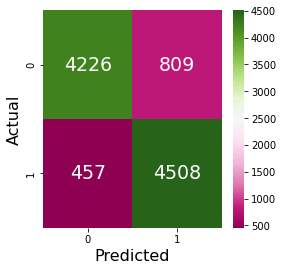

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, (model.predict(X_test1) > 0.5).astype("int32")),annot=True,cmap='PiYG',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

## CNN

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 50)           10554700  
_________________________________________________________________
conv1d (Conv1D)              (None, 150, 32)           4832      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 75, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 10,612,833
Trainable params: 10,612,833
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 77s 523ms/step - loss: 0.5135 - accuracy: 0.7024 - val_loss: 0.3035 - val_accuracy: 0.8748
Epoch 2/10
141/141 [==============================] - 73s 515ms/step - loss: 0.2584 - accuracy: 0.8996 - val_loss: 0.2756 - val_accuracy: 0.8798
Epoch 3/10
141/141 [==============================] - 72s 509ms/step - loss: 0.2101 - accuracy: 0.9223 - val_loss: 0.2992 - val_accuracy: 0.8760
Epoch 4/10
141/141 [==============================] - 68s 485ms/step - loss: 0.1725 - accuracy: 0.9388 - val_loss: 0.3716 - val_accuracy: 0.8637


In [ ]:
CNN_score=accuracy_score(y_test, (model.predict(X_test1) > 0.5).astype("int32"))
print(CNN_score)

0.8643


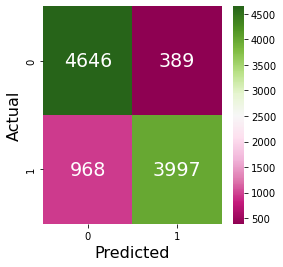

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, (model.predict(X_test1) > 0.5).astype("int32")),annot=True,cmap='PiYG',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

## LSTM

In [ ]:
embedding_vecor_length = 32
callback = EarlyStopping(monitor='val_loss', patience=2)

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 50)           10554700  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 10,615,201
Trainable params: 10,615,201
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(X_train1, y_train, epochs=10, batch_size=256,verbose = 1,validation_data=(X_valid1,y_valid),callbacks=[callback])

Epoch 1/10
141/141 [==============================] - 157s 1s/step - loss: 0.6271 - accuracy: 0.6256 - val_loss: 0.4283 - val_accuracy: 0.8292
Epoch 2/10
141/141 [==============================] - 154s 1s/step - loss: 0.3387 - accuracy: 0.8709 - val_loss: 0.3025 - val_accuracy: 0.8748
Epoch 3/10
141/141 [==============================] - 153s 1s/step - loss: 0.2679 - accuracy: 0.9003 - val_loss: 0.3383 - val_accuracy: 0.8727
Epoch 4/10
141/141 [==============================] - 153s 1s/step - loss: 0.2519 - accuracy: 0.9078 - val_loss: 0.2904 - val_accuracy: 0.8825
Epoch 5/10
141/141 [==============================] - 153s 1s/step - loss: 0.2281 - accuracy: 0.9189 - val_loss: 0.3450 - val_accuracy: 0.8748
Epoch 6/10
141/141 [==============================] - 153s 1s/step - loss: 0.2172 - accuracy: 0.9216 - val_loss: 0.3010 - val_accuracy: 0.8765


In [ ]:
LSTM_score=accuracy_score(y_test, (model.predict(X_test1) > 0.5).astype("int32"))
print(LSTM_score)

0.8769


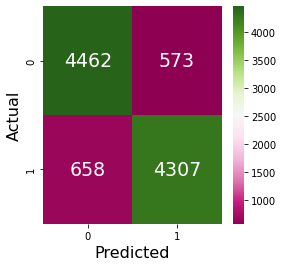

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_test, (model.predict(X_test1) > 0.5).astype("int32")),annot=True,cmap='PiYG',xticklabels=[0,1],fmt='d',annot_kws={"fontsize":19})
plt.xlabel("Predicted",fontsize=16)
plt.ylabel("Actual",fontsize=16)
plt.show()

# 8. Conclusions and Reccomendations

Text(0, 0.5, 'Accuracy (%)')

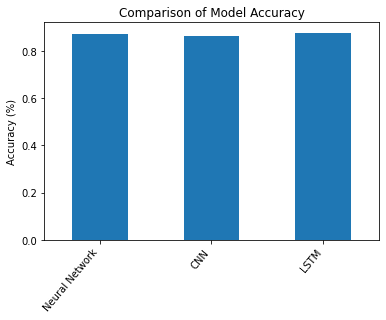

In [ ]:
#Comparing Performance
plotdata = pd.DataFrame( {"scores": [NN_score,CNN_score,LSTM_score]},
    index=['Neural Network','CNN','LSTM'])
plotdata['scores'].plot(kind='bar')
plt.xticks(rotation=50, horizontalalignment='right')
plt.title("Comparison of Model Accuracy")
plt.ylabel("Accuracy (%)")

The NN (NN), Convolutional Neural Network (CNN), and Long Short-Term Memory (LSTM) all have similar model accuracy in the high eighties. Although CNN has the highest accuracy, strictly speaking, I would recommend using the LSTM model. LSTM captures long-term dependencies between word sequences and is therefor better for text classification. 